### Analyze blocked reactions for ThermoModels under specific regression conditions

In [1]:
import os.path as path
import glob, os
from datetime import datetime
from importlib.metadata import version
import cobra
import thermo_flux
from thermo_flux.io import load_excel as ex
from thermo_flux.core.model import ThermoModel
from equilibrator_api import  Q_
import pandas as pd
from thermo_flux.io import helper_load as hl
import numpy as np
from thermo_flux.io import load_excel as ex
from scripts.logger import write_to_log
import gurobipy as gp
from gurobipy import GRB
from scripts.gen_model import gen_model
from scripts.gen_model import regress_model
from scripts.reaction_utils import list_blocked_reactions
from scripts.reaction_utils import count_blocked_pathways

In [2]:
INPUT_MODEL = "datafiles/model.xlsx"
INPUT_KEGGS = "datafiles/ecoli_kegg_id.csv"
INPUT_REED = "regression/reed.csv"
INPUT_INCHI = "regression/InChIs.csv"
INPUT_GAMS = "regression/model_Ecoli_from-gams.xlsx"
INPUT_EXP_DATA = "regression/allPhysioData_formatted_forGSM_20230831.csv"
INPUT_EXP_CONC = "regression/allConcRange_20230912.csv"
INPUT_METABOLOMICS = "regression/metabolomics-Kochanowski_20230925.csv"

MODEL_NAME = "ecoli"

OUTPUT_DIR = "output"
OUTPUT_NAME = f"blocked_reactions"
OUTPUT_LOG = f"{OUTPUT_DIR}{path.sep}{OUTPUT_NAME}_log.txt"

CONDITIONS_TO_REGRESS = ["WT-Glc_I", "WT-Gal_I", "WT-Fruc_I", "WT-Mann_I", "dptsG-Glc_I", 
                         "WT-Ace_I", "WT-Succ_I", "WT-Fum_I", "WT-Glyc_I", "WT-Pyr_I",
                         "WT-GlyCAA_II"]

INCLUDE_CO2 = True
INCLUDE_O2 = True
ALLOW_OTHER_EXCRETION = False
RELAX_EXP_FLUX_BOUNDS = 2.0

time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
write_to_log(OUTPUT_LOG, f"Started analysis at: {time}", "w")

# Write package versions:
modules = ["pandas", "numpy", "equilibrator_api", "cobra"]
write_to_log(OUTPUT_LOG, f"Package versions used:")
versions_packages = [f"  {m}: {version(m)}\n" for m in modules]
write_to_log(OUTPUT_LOG, "".join(versions_packages))

In [3]:
tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-11-02
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown m

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c NOTHING DONE!
sucsal_c NOTHING DONE!
4abu

In [4]:
tmodel_regressed = regress_model(tmodel, "WT-Glc_I", INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, ALLOW_OTHER_EXCRETION, OUTPUT_LOG)

In [5]:
blocked = list_blocked_reactions(tmodel_regressed, "WT-Glc_I", OUTPUT_LOG)

                                    Subsystem  BlockedReactionCount
0  Cofactor and Prosthetic Group Biosynthesis                    77
1                 Alternate Carbon Metabolism                    71
2                  Cell Envelope Biosynthesis                    25
3                 Nucleotide Salvage Pathways                     6
4             Arginine and Proline Metabolism                     4




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



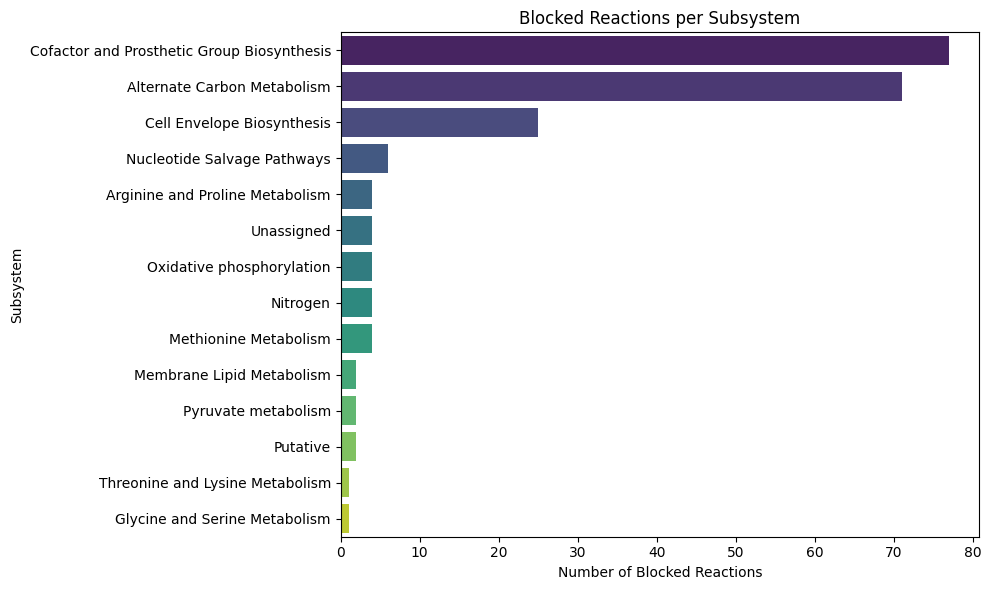

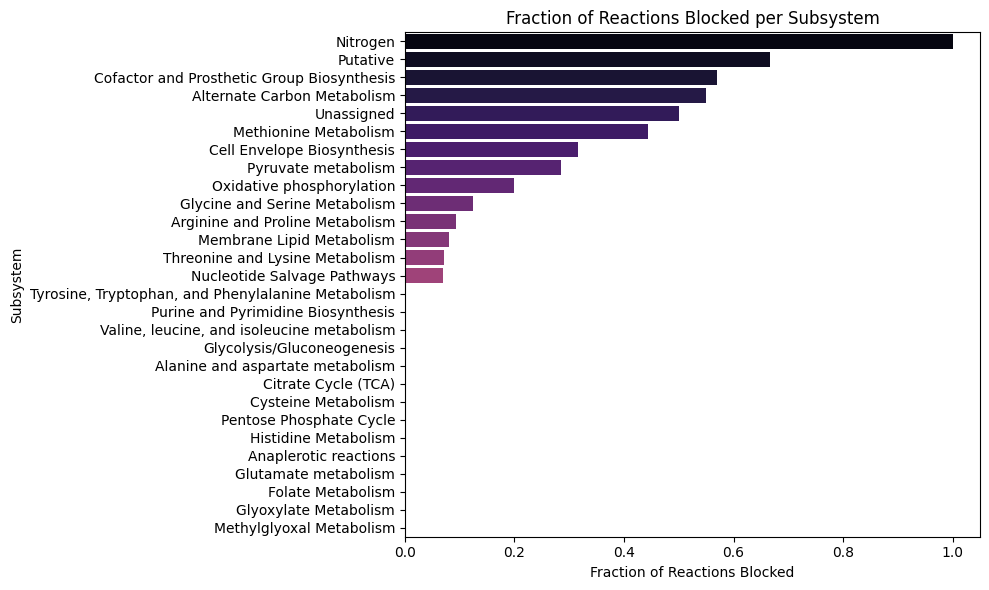

In [6]:
count_blocked_pathways(blocked, "ecoli", "WT-Glc_I", INPUT_MODEL)

In [ ]:
rxns_df = pd.read_excel(INPUT_MODEL, sheet_name="Reactions")
rxns_df.columns = rxns_df.columns.str.strip()

blocked_ids = blocked 
blocked_info = rxns_df[rxns_df["Abbrevation"].isin(blocked_ids)]

nit_all = rxns_df[rxns_df["Subsystem"].str.contains("nitrogen", case=False, na=False)]
nit_blocked = blocked_info[blocked_info["Subsystem"].str.contains("nitrogen", case=False, na=False)]

print("Nitrogen total reactions:", len(nit_all))
print("Nitrogen blocked reactions:", len(nit_blocked))
print("Fraction blocked:", len(nit_blocked) / max(1, len(nit_all)))

for n in blocked_info["Abbreviation"]:
    print(n)

Nitrogen total reactions: 4
Nitrogen blocked reactions: 4
Fraction blocked: 1.0
Abbrevation
Lower Bound
Upper Bound
Reaction
Unnamed: 4
OfficialName
Subsystem
ProteinClassDescription
Ref. (listed below)
